# Plant Diseaes

Plant Diseases are responsible for 20% to 40% of the loss in global food production \[1\]. Therefore, identifying plant diseases early to mitigate yield loss is of utmost importance. Furthermore, by automatically detecting plant diseases allows for the local use of herbicides or pesticides, which is favourable for the environment (see lecture slides). 

In this notebook, we analyze one of the most common datasets for plant disease identification, the PlantVillage dataset [1, 2]. 
Our analysis is structured into the following four steps:
1) Exploration & Data Preprocessing
3) Training
4) Evaluation
5) Conclusion

# 1. Exploration

In [22]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from random import randint
import numpy as np
import random
import imagehash
from sklearn.model_selection import train_test_split
from typing import Tuple
from keras.utils import load_img
import tensorflow as tf

tf.random.set_seed(222)

random.seed(222)

In the first step, we take a look at our data. According to paperswithcode, the dataset should consist of 38 classes and 54,303 samples [4]. Hereby, the different classes refer to a range of plants with a variety of diseases.

In [2]:
BASE_DATA_PATH = "./data/Plant_leave_diseases_dataset_without_augmentation"
class_directories = os.listdir(BASE_DATA_PATH)
print("Number of different classes: ", len(class_directories))

# the folders follow the naming convention <plant_name>___<disease_name>
plants = set([directory_name.split("___")[0] for directory_name in class_directories])
print("Different plants in the dataset: ", plants)
print("Number of different plants in the dataset: ", len(plants))

Number of different classes:  39
Different plants in the dataset:  {'Soybean', 'Apple', 'Strawberry', 'Raspberry', 'Grape', 'Corn', 'Blueberry', 'Tomato', 'Pepper,_bell', 'Potato', 'Squash', 'Peach', 'Orange', 'Background_without_leaves', 'Cherry'}
Number of different plants in the dataset:  15


It appears that the data set has one class more than stated on paperswithcode \[4\]. Looking at the given name of the different plants, we identify the *Background_without_leaves* class, which does not seem to belong to the dataset. Looking at the images that belong to the *Background_without_leaves* class, we note that they do not seem to contain images with plants (see example below). Therefore, we omit the class from the data in our further analysis to ensure comparability.

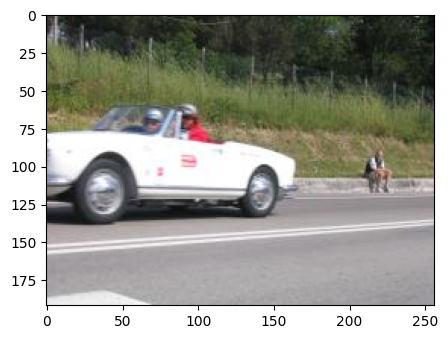

In [3]:
plt.figure(figsize=(5, 5))
plt.imshow(Image.open(f"{BASE_DATA_PATH}/Background_without_leaves/image (1).jpg"))
plt.show()
class_directories = list(
    filter(lambda dir: dir != "Background_without_leaves", class_directories)
)

Next, we verify that the number of samples matches 54,303 as described by paperswithcode [4]. Furthermore, we check whether we have to deal with class imbalance by plotting the distribution of number of samples per class.

Overall number of samples:  54305
Minimum number of samples per class: 


,class,Number of samples
0,Potato___healthy,152


Maximum number of samples per class: 


,class,Number of samples
0,Orange___Haunglongbing_(Citrus_greening),5507


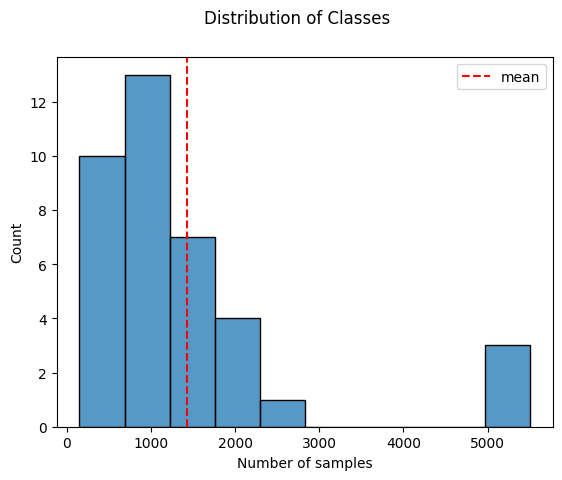

In [4]:
class_distributions = pd.DataFrame(columns=["class", "Number of samples"])
# get the number of samples per class
for folder in class_directories:
    row = pd.DataFrame(
        {
            "class": [folder],
            "Number of samples": [len(os.listdir(f"{BASE_DATA_PATH}/{folder}"))],
        }
    )
    class_distributions = pd.concat([class_distributions, row])

print("Overall number of samples: ", class_distributions["Number of samples"].sum())
print("Minimum number of samples per class: ")
display(
    class_distributions[
        class_distributions["Number of samples"]
        == class_distributions["Number of samples"].min()
    ]
)
print("Maximum number of samples per class: ")
display(
    class_distributions[
        class_distributions["Number of samples"]
        == class_distributions["Number of samples"].max()
    ]
)

plt.figure()
sns.histplot(data=class_distributions["Number of samples"])
plt.axvline(
    class_distributions["Number of samples"].mean(),
    linestyle="--",
    c="red",
    label="mean",
)
plt.suptitle("Distribution of Classes")
plt.legend()
plt.show()

As we can see, the number of samples is not evenly distributed across the classes. This is important to keep in mind, as we might need to apply some kind of sampling technique later on. Furthermore, we notice that there are two more images than expected. We also keep that in mind for our further analysis. <br>
Next, we check whether the given images are ready to be processed by a machine learning model. 
Hereby, our first step is to check the dimensions of the given images.

In [5]:
images_with_dimensions = pd.DataFrame(
    columns=["plant", "disease", "width", "height", "color", "path"]
)
for index, current_class_directory in enumerate(class_directories):
    number_of_samples_for_class = class_distributions[
        class_distributions["class"] == current_class_directory
    ]["Number of samples"].values[0]
    for i in range(1, number_of_samples_for_class + 1):
        # the image files follow the pattern image (<num>).jpg
        path = f"{BASE_DATA_PATH}/{current_class_directory}/image ({i}).JPG"
        plant, disease = current_class_directory.split("___")
        image = Image.open(path)
        image = np.asarray(image)
        x, y, c = image.shape
        row = pd.DataFrame(
            {
                "plant": [plant],
                "disease": [disease],
                "width": [x],
                "height": [y],
                "color": [c],
                "path": [path],
            }
        )
        images_with_dimensions = pd.concat([images_with_dimensions, row])
        # for healthy pepper bells, there are two files image (1).JPG (as expected) and image (1).png
        # we'll check this later
        if (
            i == number_of_samples_for_class - 1
            and current_class_directory == "Pepper,_bell___healthy"
        ):
            break

        # for tomato__late_blight, there are two files image (1).JPG and image (1).jpeg
        # we'll check this later
        if (
            i == number_of_samples_for_class - 1
            and current_class_directory == "Tomato___Late_blight"
        ):
            break
images_with_dimensions.reset_index(drop=True, inplace=True)
display(images_with_dimensions.head(5))

,plant,disease,width,height,color,path
0,Apple,Apple_scab,256,256,3,./data/Plant_leave_diseases_dataset_without_au...
1,Apple,Apple_scab,256,256,3,./data/Plant_leave_diseases_dataset_without_au...
2,Apple,Apple_scab,256,256,3,./data/Plant_leave_diseases_dataset_without_au...
3,Apple,Apple_scab,256,256,3,./data/Plant_leave_diseases_dataset_without_au...
4,Apple,Apple_scab,256,256,3,./data/Plant_leave_diseases_dataset_without_au...


In [6]:
# should be 54,303
print(len(images_with_dimensions))
print(images_with_dimensions["width"].unique())
print(images_with_dimensions["height"].unique())
print(images_with_dimensions["color"].unique())

54303
[256]
[256]
[3]


All images have the same size, 256x256x3, which is good for now. <br> Next, we check the two images that do not follow the given naming schema

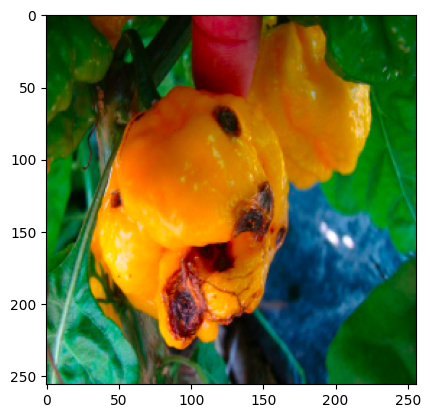

In [7]:
plt.figure()
# should be a healthy bell pepper
# but does not look like it
# therefore, we will omit the image in our further analysis
plt.imshow(Image.open(f"{BASE_DATA_PATH}/Pepper,_bell___healthy/image (1).png"))
plt.show()

<Figure size 640x480 with 0 Axes>

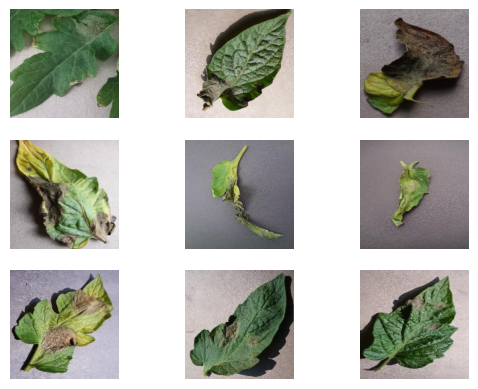

In [8]:
plt.figure()
fig, ax = plt.subplots(3, 3)

for index, row in enumerate(ax):
    for i, col in enumerate(row):
        col.set_axis_off()

        # should be a tomato with late blight
        if (index, i) == (0, 0):
            col.imshow(
                Image.open(f"{BASE_DATA_PATH}/Tomato___Late_blight/image ({1}).jpeg")
            )
            continue

        number = randint(1, 100)
        col.imshow(
            Image.open(f"{BASE_DATA_PATH}/Tomato___Late_blight/image ({number}).JPG")
        )

plt.show()

#

In this case, it's harder to tell whether the image in the top left corner fits the other images in this class. However, as stated above, the dataset is supposed to consist of 53,303 images [4]. Therefore, We will omit the image in the top left corner for our further analysis.

In the next step, we check the dataset for duplicate images by using the phash of the given images.

In [9]:
hashes = []

for index, row in images_with_dimensions.iterrows():
    image = Image.open(row["path"])

    hash = imagehash.phash(image)

    hashes.append(hash.__str__())

images_with_dimensions["hash"] = pd.Series(hashes)

<details>
    <summary>
    GPT
    </summary>
    How do I remove spacing between subplots in pyplot?
</details>

54281
54303


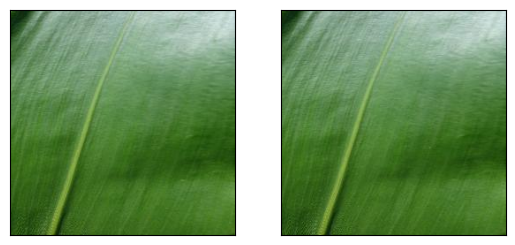

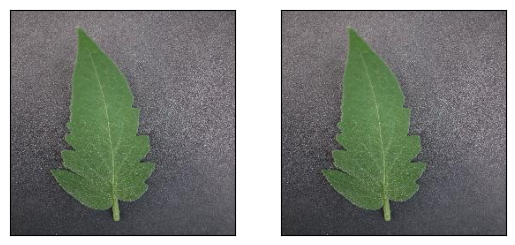

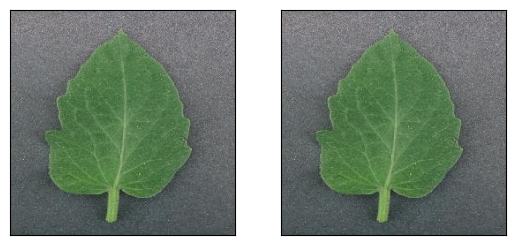

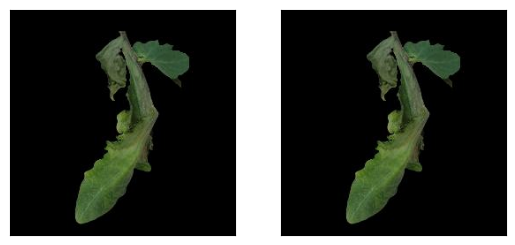

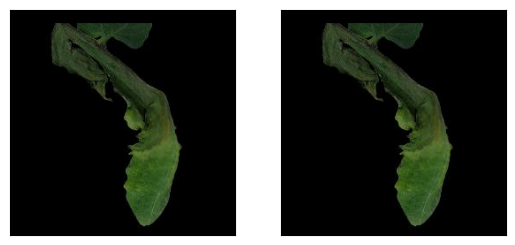

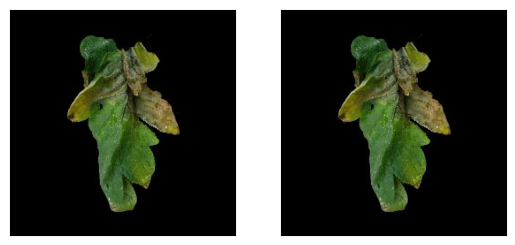

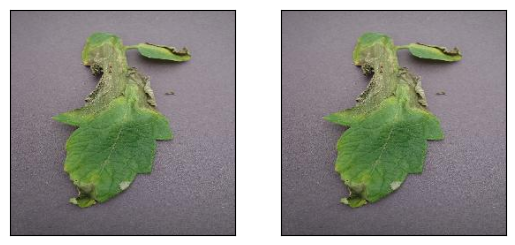

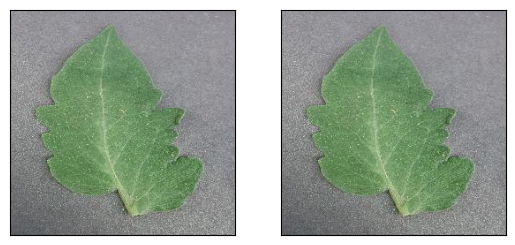

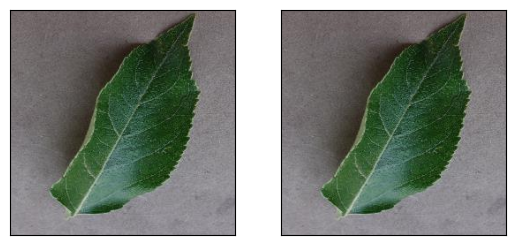

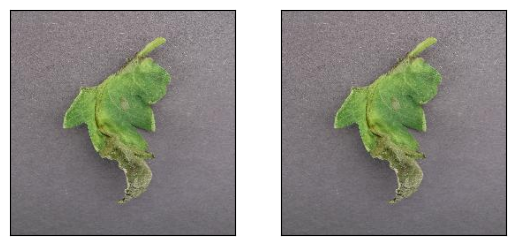

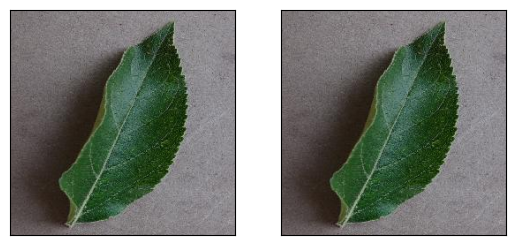

44
44


In [10]:
# should be 54,303 if there are no duplicate images
# but is 54,281, so it seems we have duplicates
print(len(images_with_dimensions["hash"].unique()))
print(len(images_with_dimensions))

# let's see if our duplicate detection works as expected and the images are actual duplicates
duplicate_images = (
    images_with_dimensions[
        images_with_dimensions["hash"].isin(
            images_with_dimensions["hash"][images_with_dimensions["hash"].duplicated()]
        )
    ]
    .sort_values(by="hash")
    .reset_index(drop=True)
)

num_rows = int(len(duplicate_images) / 2)

# plot duplicates side by side to compare
for row in range(0, num_rows, 2):
    plt.subplot(121)
    plt.imshow(Image.open(duplicate_images.loc[row, "path"]))
    plt.xticks([])
    plt.yticks([])

    plt.subplot(122)
    plt.imshow(Image.open(duplicate_images.loc[row + 1, "path"]))
    plt.xticks([])
    plt.yticks([])
    plt.show()


print(len(duplicate_images))
print(duplicate_images["path"].nunique())

Looking at the images above, we find that these images are actual duplicates, which we can remove from the dataset.

In [11]:
data = images_with_dimensions.drop_duplicates(subset="hash")
display(data.head(5))
display(len(data))

,plant,disease,width,height,color,path,hash
0,Apple,Apple_scab,256,256,3,./data/Plant_leave_diseases_dataset_without_au...,fcb3a19ec5894a4a
1,Apple,Apple_scab,256,256,3,./data/Plant_leave_diseases_dataset_without_au...,da93a56956cd0ab4
2,Apple,Apple_scab,256,256,3,./data/Plant_leave_diseases_dataset_without_au...,d4f52a4ab9ba90a3
3,Apple,Apple_scab,256,256,3,./data/Plant_leave_diseases_dataset_without_au...,a9b7d298cb898c4e
4,Apple,Apple_scab,256,256,3,./data/Plant_leave_diseases_dataset_without_au...,faa1e187979a129a


54281

Finally, we conclude Phase 1: Exploration & Data Preprocessing by splitting our data into training, validation and test set.
Similar to the paper with the highest number of upvotes on paperswithcode [4], we split our data into 90% training, 5% validation and 5% test set [5]. As we found out before, we need to be aware of the class imbalance in the dataset. However, according to [5], we apply our data split for each of the classes separately, i.e. for each class, 90% of the samples are used for training and 5% for validation and testing, respectively. <br>
Since ~50k images is a whole lot, we also create a smaller train test validation split with 100 samples per class.

<details>
    <summary>
    GPT
    </summary>
    how do I rewrite this code to prevent from the SettingWithCopyWarning:
    Code: """
    data["label"] = data["plant"] + data["disease"]
    """
</details>

In [12]:
data = data.assign(label=data["plant"] + data["disease"])
display(data["label"].nunique())

train_small = pd.DataFrame()
test_small = pd.DataFrame()
validation_small = pd.DataFrame()

train_small = pd.DataFrame()
train = pd.DataFrame()
test_small = pd.DataFrame()
test = pd.DataFrame()
validation_small = pd.DataFrame()
validation = pd.DataFrame()
for label in data["label"].unique():
    data_for_label = data[data["label"] == label].reset_index(drop=True)

    # small
    train_current_small = data_for_label[:90]
    validation_current_small = data_for_label[90:95]
    test_current_small = data_for_label[95:100]

    # all data
    train_current_label, test_current_label = train_test_split(
        data_for_label, test_size=0.1
    )
    test_current_label, validation_current_label = train_test_split(
        test_current_label, test_size=0.5
    )

    train = pd.concat([train, train_current_label])
    validation = pd.concat([validation, validation_current_label])
    test = pd.concat([test, test_current_label])
    train_small = pd.concat([train_small, train_current_small])
    validation_small = pd.concat([validation_small, validation_current_small])
    test_small = pd.concat([test_small, test_current_small])
print(
    "Sanity check for small: ",
    len(train_small) + len(test_small) + len(validation_small)
    == data["label"].nunique() * 100,
)

print("Number of samples: ", len(data))
print("Number of training samples: ", len(train))
print("Number of test samples: ", len(test))
print("Number of validation: ", len(validation))
print("Sanity check: ", len(train) + len(test) + len(validation) == len(data))

38

Sanity check for small:  True
Number of samples:  54281
Number of training samples:  48836
Number of test samples:  2716
Number of validation:  2729
Sanity check:  True


# 2. Training

At first, we need to load the data and assign the respective labels. We're using the small datasets for now. As a first step, we want to see whether some basic machine learning models can learn "something" from our data.

In [20]:
def load_and_label_data(data: pd.DataFrame) -> Tuple:
    X, y = [], []
    for _, row in data.iterrows():
        # based on the code from the exercise
        img = load_img(row["path"], target_size=(256, 256, 3))
        img = image.img_to_array(img)
        img = img / 255
        X.append(img)
        y.append(row["label"])
    return X, y


X_train, y_train = load_and_label_data(train_small)
X_validation, y_validation = load_and_label_data(validation_small)
X_test, y_test = load_and_label_data(test_small)

As a sanity check, we train a random forest classifier and see whether it performs better than random guessing. Since we have 38 different classes, random guessing should achieve an accuracy of roughly 1/38 (~3%) on our balanced small datasets.

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# as discussed in the exercise, we need to flatten the data for "regular machine learning"
X_train_flat = [element.flatten() for element in X_train]
X_val_flat = [element.flatten() for element in X_validation]

model = RandomForestClassifier()

model.fit(X_train_flat, y_train)
predictions = model.predict(X_val_flat)

accuracy_score(y_validation, predictions)

0.5473684210526316

An accuracy of 0.54 already looks reasonable. Next up, we try and train a convolutional neural network. The following code is mostly based on what we learned during the exercise. The goal is to get a first impression on how well convolutional neural networks perform on the given dataset. To achieve this, we need to onehot encode the labels first. Then, we can define a model.

<details>
    <summary>
    GPT
    </summary>
    how many neurons should a dense layer in a convolutional neural network have?
</details>

In [80]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)

y_train_encoded = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
y_validation_encoded = encoder.transform(np.array(y_validation).reshape(-1, 1))


model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(
            16, (3, 3), activation="relu", input_shape=((256, 256, 3)), padding="same"
        ),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation="relu"),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(38),
    ]
)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 32, 32, 64)     

In [79]:
display(np.array(X_train)[0])

array([[[0.627451  , 0.5803922 , 0.59607846],
        [0.6313726 , 0.58431375, 0.6       ],
        [0.6313726 , 0.58431375, 0.6       ],
        ...,
        [0.5686275 , 0.5058824 , 0.50980395],
        [0.5568628 , 0.49411765, 0.49803922],
        [0.54901963, 0.4862745 , 0.49019608]],

       [[0.627451  , 0.5803922 , 0.59607846],
        [0.627451  , 0.5803922 , 0.59607846],
        [0.627451  , 0.5803922 , 0.59607846],
        ...,
        [0.5529412 , 0.49019608, 0.49411765],
        [0.54509807, 0.48235294, 0.4862745 ],
        [0.5411765 , 0.47843137, 0.48235294]],

       [[0.63529414, 0.5882353 , 0.6039216 ],
        [0.6313726 , 0.58431375, 0.6       ],
        [0.627451  , 0.5803922 , 0.59607846],
        ...,
        [0.5529412 , 0.49019608, 0.49411765],
        [0.5568628 , 0.49411765, 0.49803922],
        [0.5568628 , 0.49411765, 0.49803922]],

       ...,

       [[0.5921569 , 0.5647059 , 0.5921569 ],
        [0.5882353 , 0.56078434, 0.5882353 ],
        [0.5803922 , 0

In [81]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [85]:
from sklearn.utils import shuffle

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

X_train_shuffled, y_train_shuffled = shuffle(np.array(X_train), y_train_encoded)
X_test_shuffled, y_test_shuffled = shuffle(np.array(X_test), y_validation_encoded)
history = model.fit(
    X_train_shuffled,
    y_train_shuffled,
    batch_size=3,
    epochs=20,
    verbose=1,
    validation_data=(X_test_shuffled, y_test_shuffled),
    callbacks=[callback],
)

Epoch 1/20
1140/1140 [==============================] - 808s 709ms/step - loss: 7.6349 - accuracy: 0.0263 - val_loss: 7.6349 - val_accuracy: 0.0263
Epoch 2/20
1140/1140 [==============================] - 758s 664ms/step - loss: 7.6349 - accuracy: 0.0263 - val_loss: 7.6349 - val_accuracy: 0.0263
Epoch 3/20
 374/1140 [========>.....................] - ETA: 8:53 - loss: 7.6712 - accuracy: 0.0241

KeyboardInterrupt: 

In [64]:
print(len(y_validation_encoded))
print(len(X_validation))

190
190


\[1\]: https://doi.org/10.1016/j.atech.2022.100083 <br>
\[2\]: https://www.tensorflow.org/datasets/catalog/plant_village <br>
\[3\]: https://arxiv.org/pdf/2312.07905v1.pdf <br>
\[4\]: https://paperswithcode.com/dataset/plantvillage
\[5\]: https://arxiv.org/pdf/2209.07326v3.pdf